<a href="https://colab.research.google.com/github/Koks-creator/PytorchReviewClassification/blob/main/PytorchReviewAnalysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import files
from dataclasses import dataclass
import os
import glob
from typing import Tuple, Union
from collections import Counter
import re
import string
import pandas as pd
import numpy as np
from tqdm import tqdm
import nltk
from nltk.corpus import stopwords
import tensorflow
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
from zipfile import ZipFile
import matplotlib.pyplot as plt
import pickle
import keras

In [ ]:
uploaded = files.upload()
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json


In [ ]:
!kaggle datasets download -d lakshmi25npathi/imdb-dataset-of-50k-movie-reviews

 89% 23.0M/25.7M [00:00<00:00, 123MB/s] 
100% 25.7M/25.7M [00:00<00:00, 109MB/s]


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
device

device(type='cuda')

In [ ]:
REVIEW_COLUMN = "review"
LABEL_COLUMN = "sentiment"
ZIP_FILEPATH = "/content/imdb-dataset-of-50k-movie-reviews.zip"
CSV_FILEPATH = "/content/IMDB Dataset.csv"

TRAIN_PERC = .8
BATCH_SIZE = 32
NUM_EPOCHS = 10
LEARNING_RATE = 0.001
DIM_SIZE = 64
LSTM_LAYERS = 2
MAXLEN = 200

CLASSES = ["Positive", "Negative"]
MODEL_PATH = "ReviewModel.pt"
TOKENIZER_PATH = "tokenizer.pkl"

In [ ]:
with ZipFile(ZIP_FILEPATH, 'r') as zip:
  zip.extractall()
  print("Done")

Done


**Preparing dataset**

In [ ]:
df = pd.read_csv(CSV_FILEPATH)
df.columns

Index(['review', 'sentiment'], dtype='object')

In [ ]:
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [ ]:
df["sentiment"] = df["sentiment"].apply(lambda x: 0 if x == "positive" else 1)

In [ ]:
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,0
1,A wonderful little production. <br /><br />The...,0
2,I thought this was a wonderful way to spend ti...,0
3,Basically there's a family where a little boy ...,1
4,"Petter Mattei's ""Love in the Time of Money"" is...",0


In [ ]:
@dataclass
class DataCleaning:
    def __post_init__(self):
        try:
            self.stop_words = set(stopwords.words('english'))
        except LookupError:
            nltk.download('stopwords')
            self.stop_words = set(stopwords.words('english'))

    @staticmethod
    def remove_html_tags(raw_text: str) -> str:
        cleanr = re.compile("<.*?>")
        cleantext = re.sub(cleanr, '', raw_text)
        return cleantext

    @staticmethod
    def remove_url(text: str) -> str:
        url_pattern = re.compile(r"http[s]?://\S+.\S+.\S+")
        return url_pattern.sub(r"", text)

    @staticmethod
    def remove_punct(text: str) -> str:
        translator = str.maketrans("", "", string.punctuation)
        return text.translate(translator)

    @staticmethod
    def remove_non_ascii(text: str) -> str:
        pattern = re.compile(r"[^\x00-\x7f][^\x8d,\x10][ ]?")
        return pattern.sub(r"", text)

    @staticmethod
    def remove_digits(text: str) -> str:
        pattern = re.compile(r"\b\d+\b")
        return pattern.sub(r"", text)

    def remove_stopword(self, text: str) -> str:
        filtered_text = [word.lower() for word in text.split() if word.lower() not in self.stop_words]
        return " ".join(filtered_text)

In [ ]:
pr = DataCleaning()

df[REVIEW_COLUMN] = df[REVIEW_COLUMN].apply(lambda x: pr.remove_html_tags(x))
df[REVIEW_COLUMN] = df[REVIEW_COLUMN].apply(lambda x: pr.remove_url(x))
df[REVIEW_COLUMN] = df[REVIEW_COLUMN].apply(lambda x: pr.remove_punct(x))
df[REVIEW_COLUMN] = df[REVIEW_COLUMN].apply(lambda x: pr.remove_non_ascii(x))
df[REVIEW_COLUMN] = df[REVIEW_COLUMN].apply(lambda x: pr.remove_digits(x))
# df[REVIEW_COLUMN] = df[REVIEW_COLUMN].apply(lambda x: pr.remove_stopword(x))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,0
1,A wonderful little production The filming tech...,0
2,I thought this was a wonderful way to spend ti...,0
3,Basically theres a family where a little boy J...,1
4,Petter Matteis Love in the Time of Money is a ...,0


In [ ]:
def count_words(column: pd.Series) -> Counter:
    count = Counter()

    for row in column.values:
        for word in row.split():
            count[word] += 1

    return count

In [ ]:
word_counter = count_words(df[REVIEW_COLUMN])

In [ ]:
word_counter.most_common()

[('the', 571930),
 ('a', 308355),
 ('and', 306210),
 ('of', 284835),
 ('to', 263349),
 ('is', 207993),
 ('in', 172687),
 ('I', 136129),
 ('that', 132167),
 ('it', 128789),
 ('this', 119688),
 ('was', 94526),
 ('as', 84627),
 ('with', 84422),
 ('for', 82362),
 ('movie', 82299),
 ('The', 75536),
 ('film', 73495),
 ('but', 67364),
 ('on', 64398),
 ('are', 57572),
 ('not', 54586),
 ('have', 54571),
 ('his', 54482),
 ('you', 53640),
 ('be', 52289),
 ('one', 46290),
 ('at', 43199),
 ('by', 42758),
 ('he', 42674),
 ('an', 41300),
 ('all', 40919),
 ('who', 38778),
 ('from', 38498),
 ('like', 37463),
 ('its', 35748),
 ('they', 35502),
 ('so', 33984),
 ('or', 33626),
 ('about', 33429),
 ('her', 32857),
 ('has', 32670),
 ('just', 32607),
 ('out', 32225),
 ('some', 28411),
 ('good', 27399),
 ('more', 27092),
 ('very', 26293),
 ('This', 25259),
 ('what', 24153),
 ('up', 23892),
 ('would', 23750),
 ('when', 23038),
 ('time', 22738),
 ('if', 22658),
 ('which', 22421),
 ('really', 22190),
 ('their', 2

In [ ]:
num_unique_words = len(word_counter)
num_unique_words

257631

In [ ]:
train_size = int(TRAIN_PERC * len(df))

In [ ]:
train_df = df[:train_size]
val_df = df[train_size:]

train_reviews = train_df[REVIEW_COLUMN].to_numpy()
train_labels = train_df[LABEL_COLUMN].to_numpy()
# train_labels = train_labels.reshape(train_labels.shape[0], 1)


val_reviews = val_df[REVIEW_COLUMN].to_numpy()
val_labels = val_df[LABEL_COLUMN].to_numpy()
# val_labels = val_labels.reshape(val_labels.shape[0], 1)

In [ ]:
train_labels.shape

(40000,)

In [ ]:
tokenizer = Tokenizer(num_words=num_unique_words)
tokenizer.fit_on_texts(train_reviews)

In [ ]:
words_index = tokenizer.word_index

In [ ]:
words_index

{'the': 1,
 'and': 2,
 'a': 3,
 'of': 4,
 'to': 5,
 'is': 6,
 'in': 7,
 'it': 8,
 'this': 9,
 'i': 10,
 'that': 11,
 'was': 12,
 'as': 13,
 'with': 14,
 'for': 15,
 'movie': 16,
 'but': 17,
 'film': 18,
 'on': 19,
 'not': 20,
 'you': 21,
 'are': 22,
 'his': 23,
 'have': 24,
 'be': 25,
 'he': 26,
 'one': 27,
 'its': 28,
 'at': 29,
 'all': 30,
 'by': 31,
 'an': 32,
 'they': 33,
 'who': 34,
 'from': 35,
 'like': 36,
 'so': 37,
 'or': 38,
 'just': 39,
 'her': 40,
 'about': 41,
 'has': 42,
 'out': 43,
 'if': 44,
 'some': 45,
 'what': 46,
 'there': 47,
 'good': 48,
 'more': 49,
 'very': 50,
 'when': 51,
 'even': 52,
 'up': 53,
 'would': 54,
 'my': 55,
 'no': 56,
 'she': 57,
 'time': 58,
 'which': 59,
 'only': 60,
 'really': 61,
 'their': 62,
 'see': 63,
 'were': 64,
 'story': 65,
 'had': 66,
 'can': 67,
 'me': 68,
 'than': 69,
 'much': 70,
 'we': 71,
 'well': 72,
 'been': 73,
 'get': 74,
 'will': 75,
 'into': 76,
 'other': 77,
 'bad': 78,
 'great': 79,
 'because': 80,
 'do': 81,
 'people': 8

In [ ]:
"not" in words_index.keys()

True

In [ ]:
train_sequences = tokenizer.texts_to_sequences(train_reviews)
val_sequences = tokenizer.texts_to_sequences(val_reviews)

In [ ]:
train_padded = pad_sequences(train_sequences, maxlen=MAXLEN, padding="pre", truncating="pre")
val_padded = pad_sequences(val_sequences, maxlen=MAXLEN, padding="pre", truncating="pre")

train_padded.shape, val_padded.shape

((40000, 200), (10000, 200))

In [ ]:
val_padded[0]

array([     0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
           87,    123,     10,    175,      5,    127,     11,     10,
         6890,   3861,     19,      1,    989,   2477,      2,     10,
          245,      1,     16,   2359,     10,   1230,      5,    102,
            1,    214, 111539,   6358,      4,      3,     18,      9,
           16,    915,      3,    463,      5,    210,    976,    437,
            8,     12,    210,   1340,     55,    406,    298,      4,
           22,    249,     18,    872,     11,  20372,     11,     33,
           67,     60,    208,     53,     14,      9,    110,     12,
          487,      2,      1,     99,     64,   5140,     15,      1,
      

In [ ]:
reverse_word_index = dict([(idx, word) for (word, idx) in words_index.items()])

In [ ]:
def decode_seq(seq):
    return " ".join([reverse_word_index.get(index, "?") for index in seq])

In [ ]:
data_transforms = transforms.Compose([
    transforms.ToTensor()
])

In [ ]:
class CustomDataset(Dataset):
    def __init__(self, x, y, transform=None):
        self.x = x
        self.y = y
        self.transform = transform

    def __getitem__(self, index: int):

        return self.x[index], torch.Tensor([self.y[index]])

    def __len__(self):
        return len(self.x)

In [ ]:
train_labels[0]

0

In [ ]:
train_dataset = CustomDataset(x=train_padded, y=train_labels, transform=data_transforms)
test_dataset = CustomDataset(x=val_padded, y=val_labels, transform=data_transforms)

In [ ]:
train_loader = DataLoader(dataset=train_dataset,
                          batch_size=BATCH_SIZE,
                          shuffle=True,
                          num_workers=2)

test_loader = DataLoader(dataset=test_dataset,
                          batch_size=BATCH_SIZE,
                          shuffle=False,
                          num_workers=2)

In [ ]:
dataiter = iter(train_loader)
reviews, labels = next(dataiter)

In [ ]:
labels.shape

torch.Size([32, 1])

**Training**

In [ ]:
class ReviewModel(nn.Module):
    def __init__(self, input_size: int, dim_size: int, lstm_layers: int):
        super(ReviewModel, self).__init__()

        self.input_size = input_size
        self.dim_size = dim_size
        self.lstm_layers = lstm_layers

        self.dropout = nn.Dropout(0.5)
        self.embedding = nn.Embedding(self.input_size, self.dim_size, padding_idx=0)
        self.lstm = nn.LSTM(input_size=self.dim_size, hidden_size=self.dim_size, num_layers=self.lstm_layers, batch_first=True)
        self.fc1 = nn.Linear(in_features=self.dim_size, out_features=64)
        self.fc2 = nn.Linear(64, 1)


    def forward(self, x):
        h = torch.zeros((self.lstm_layers, x.size(0), self.dim_size), device=x.device)
        c = torch.zeros((self.lstm_layers, x.size(0), self.dim_size), device=x.device)

        torch.nn.init.xavier_normal_(h)
        torch.nn.init.xavier_normal_(c)

        out = self.embedding(x)
        out, (hidden, cell) = self.lstm(out, (h,c))

        out = torch.relu_(self.fc1(out[:,-1,:]))
        out = self.dropout(out)
        out = torch.nn.functional.sigmoid(self.fc2(out))

        return out



In [ ]:
model = ReviewModel(num_unique_words, DIM_SIZE, LSTM_LAYERS)
model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
# optimizer = torch.optim.RMSprop(model.parameters(), lr=LEARNING_RATE)
criterion = nn.BCELoss()

In [ ]:
def get_test_accuracy(data_loader: DataLoader, model, loss_function) -> Tuple[float, float]:
    n_correct = 0
    n_samples = 0
    test_loss = 0

    model.eval()

    with torch.no_grad():
        for review, labels in train_loader:
            review = review.to(device)
            labels = labels.float().to(device)

            outputs = model(review)
            test_loss  = loss_function(outputs, labels)

            rounded_preds = torch.round(outputs)

            n_samples += labels.size(0)
            n_correct += torch.sum(rounded_preds == labels)

    model.train()
    return 100 * n_correct/n_samples, test_loss

In [ ]:
train_loss_history = []
test_loss_history = []
train_accuracy_history = []
test_accuracy_history = []

for epoch in range(NUM_EPOCHS):
    num_correct_train = 0
    num_samples_train = 0
    print(f"------------------- EPOCH {epoch+1}/{NUM_EPOCHS} -------------------")

    for (train_reviews, train_labels) in tqdm(train_loader, total=len(train_loader)):
        train_reviews = train_reviews.to(device)
        train_labels = train_labels.float().to(device)

        # forward pass
        train_predictions = model(train_reviews)
        loss = criterion(train_predictions, train_labels)

        # calcuate train loss and accuracy
        train_predictions_rounded = torch.round(train_predictions)
        num_correct_train += torch.sum(train_predictions_rounded == train_labels)
        num_samples_train += len(train_labels)

        # backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    train_acc = 100 * num_correct_train / num_samples_train
    test_acc, test_loss = get_test_accuracy(test_loader, model, criterion)

    print(f'\nEpoch [{epoch+1}/{NUM_EPOCHS}] | Loss: {loss.item():.4f}, Test loss: {test_loss:.4f} | Acc: {train_acc:.4f}, Test acc: {test_acc:.4f}')

    train_loss_history.append(loss.item())
    test_loss_history.append(test_loss.item())
    train_accuracy_history.append(train_acc.item())
    test_accuracy_history.append(test_acc.item())



------------------- EPOCH 1/10 -------------------


100%|██████████| 1250/1250 [00:14<00:00, 89.20it/s] 



Epoch [1/10] | Loss: 0.5615, Test loss: 0.6163 | Acc: 66.3350, Test acc: 68.2525
------------------- EPOCH 2/10 -------------------


100%|██████████| 1250/1250 [00:13<00:00, 92.06it/s] 



Epoch [2/10] | Loss: 0.6018, Test loss: 0.2750 | Acc: 81.1150, Test acc: 86.1775
------------------- EPOCH 3/10 -------------------


100%|██████████| 1250/1250 [00:13<00:00, 95.66it/s] 



Epoch [3/10] | Loss: 0.2678, Test loss: 0.4338 | Acc: 86.4150, Test acc: 88.8525
------------------- EPOCH 4/10 -------------------


100%|██████████| 1250/1250 [00:12<00:00, 96.59it/s]



Epoch [4/10] | Loss: 0.2912, Test loss: 0.0878 | Acc: 89.5225, Test acc: 92.6950
------------------- EPOCH 5/10 -------------------


100%|██████████| 1250/1250 [00:12<00:00, 98.62it/s]



Epoch [5/10] | Loss: 0.1753, Test loss: 0.1066 | Acc: 91.0200, Test acc: 93.7700
------------------- EPOCH 6/10 -------------------


100%|██████████| 1250/1250 [00:12<00:00, 96.88it/s] 



Epoch [6/10] | Loss: 0.2742, Test loss: 0.0466 | Acc: 94.3675, Test acc: 96.6300
------------------- EPOCH 7/10 -------------------


100%|██████████| 1250/1250 [00:12<00:00, 99.23it/s] 



Epoch [7/10] | Loss: 0.2577, Test loss: 0.0795 | Acc: 95.9900, Test acc: 97.7025
------------------- EPOCH 8/10 -------------------


100%|██████████| 1250/1250 [00:13<00:00, 95.34it/s] 



Epoch [8/10] | Loss: 0.0510, Test loss: 0.0474 | Acc: 97.3750, Test acc: 98.6450
------------------- EPOCH 9/10 -------------------


100%|██████████| 1250/1250 [00:12<00:00, 98.37it/s] 



Epoch [9/10] | Loss: 0.1583, Test loss: 0.0276 | Acc: 98.0650, Test acc: 98.7325
------------------- EPOCH 10/10 -------------------


100%|██████████| 1250/1250 [00:12<00:00, 98.18it/s] 



Epoch [10/10] | Loss: 0.0153, Test loss: 0.0057 | Acc: 98.5275, Test acc: 99.3425


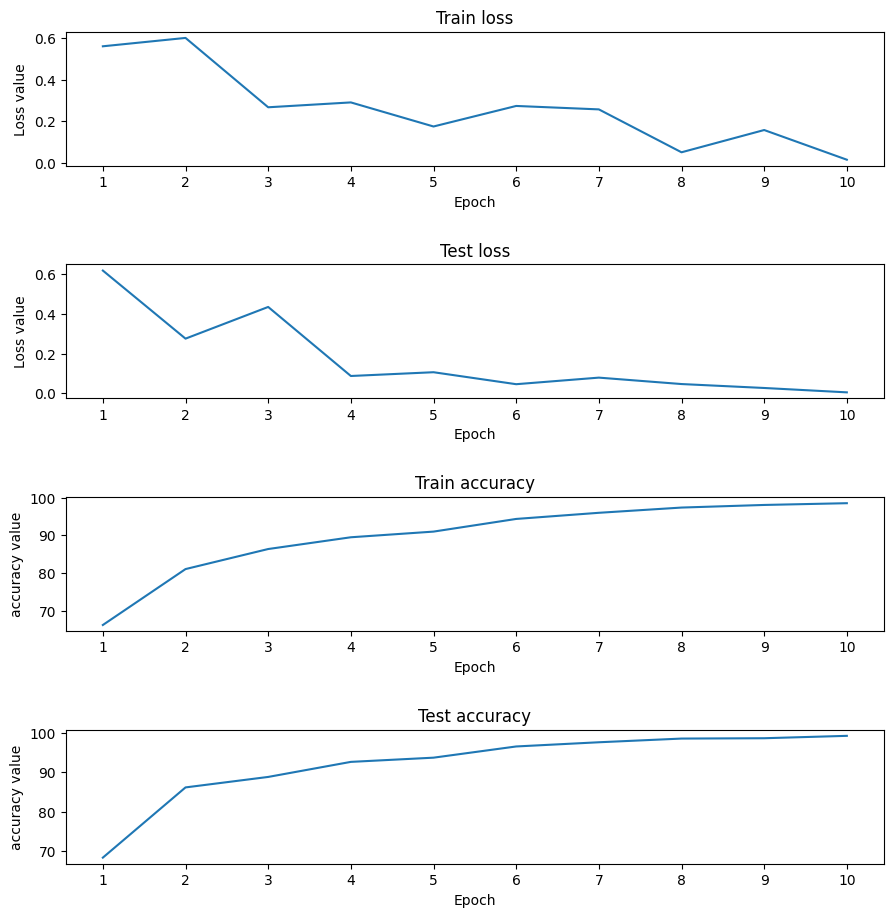

In [ ]:
fig, ax = plt.subplots(4, figsize=(10, 10))
fig.tight_layout(pad=5.0)
plt.setp(ax, xticks=[i for i in range(NUM_EPOCHS)], xticklabels=[i+1 for i in range(NUM_EPOCHS)])

ax[0].plot(train_loss_history, label="Train loss")
ax[0].set_title("Train loss")
ax[0].set_xlabel("Epoch")
ax[0].set_ylabel("Loss value")

ax[1].plot(test_loss_history, label="Test loss")
ax[1].set_title("Test loss")
ax[1].set_xlabel("Epoch")
ax[1].set_ylabel("Loss value")


ax[2].plot(train_accuracy_history, label="Train accuracy")
ax[2].set_title("Train accuracy")
ax[2].set_xlabel("Epoch")
ax[2].set_ylabel("accuracy value")

ax[3].plot(test_accuracy_history, label="Test accuracy")
ax[3].set_title("Test accuracy")
ax[3].set_xlabel("Epoch")
ax[3].set_ylabel("accuracy value")

plt.show()

**Testing**

In [ ]:
with torch.no_grad():
    n_correct = 0
    n_samples = 0
    n_class_correct = [0 for i in range(2)]
    n_class_samples = [0 for i in range(2)]


    for (test_reviews, test_labels) in tqdm(test_loader, total=len(test_loader)):
        test_reviews = test_reviews.to(device)
        test_labels = test_labels.float().to(device)

        test_predictions = model(test_reviews)
        test_predictions_rounded = torch.round(test_predictions)

        n_correct += torch.sum((test_predictions_rounded == test_labels)).item()
        n_samples += len(test_labels)

        if len(test_labels) == BATCH_SIZE:
            for i in range(BATCH_SIZE):
                label = test_labels[i].int().item()
                pred = test_predictions_rounded[i]

                if label == pred:
                    n_class_correct[label] += 1
                n_class_samples[label] += 1

print()
acc = 100 * n_correct / n_samples
print(f"Overall accuracy: {acc}")
print(f"Accuracy for positive class: {100 * n_class_correct[0]/n_class_samples[0]:.2f}")
print(f"Accuracy for negative class: {100 * n_class_correct[1]/n_class_samples[1]:.2f}")


100%|██████████| 313/313 [00:02<00:00, 117.00it/s]


Overall accuracy: 86.21
Accuracy for positive class: 86.19
Accuracy for negative class: 86.21


**Saving and loading**

In [ ]:
model_scripted = torch.jit.script(model)
model_scripted.save(MODEL_PATH)

with open(TOKENIZER_PATH, "wb") as f:
    pickle.dump(tokenizer, f)

In [ ]:
with open(TOKENIZER_PATH, "rb") as f:
    tokenizer = pickle.load(f)

model = torch.jit.load(MODEL_PATH)  # when using cpu add map_location=torch.device('cpu')
model.eval()

RecursiveScriptModule(
  original_name=ReviewModel
  (dropout): RecursiveScriptModule(original_name=Dropout)
  (embedding): RecursiveScriptModule(original_name=Embedding)
  (lstm): RecursiveScriptModule(original_name=LSTM)
  (fc1): RecursiveScriptModule(original_name=Linear)
  (fc2): RecursiveScriptModule(original_name=Linear)
)

**Making predictions**

In [ ]:
class Predictor(DataCleaning):
    def __init__(self) -> None:
        super().__init__()
        self.review_col, self.label_col, self.class_name_col = ["Review", "ClassIndex", "Class"]
        self.classes = ["Positive", "Negative"]

    def clean_data(self, data: pd.DataFrame) ->  pd.DataFrame:
        data[self.review_col] = data[self.review_col].apply(lambda x: self.remove_html_tags(x))
        data[self.review_col] = data[self.review_col].apply(lambda x: self.remove_url(x))
        data[self.review_col] = data[self.review_col].apply(lambda x: self.remove_punct(x))
        data[self.review_col] = data[self.review_col].apply(lambda x: self.remove_non_ascii(x))
        data[self.review_col] = data[self.review_col].apply(lambda x: self.remove_digits(x))

        return data

    def make_predictions(self, model, sents_list: list,
                         tokenizer: tensorflow.keras.preprocessing.text.Tokenizer,
                         max_length: int = 200, device = None) -> pd.DataFrame:

        df = pd.DataFrame({self.review_col: sents_list})
        df_original = df.copy()
        cleaned_df = self.clean_data(df)

        reviews = cleaned_df[self.review_col].to_numpy()
        sequences = tokenizer.texts_to_sequences(reviews)
        sequences_padded = pad_sequences(sequences, maxlen=max_length, padding="pre", truncating="pre")
        sequences_padded = torch.from_numpy(sequences_padded)

        if device:
            sequences_padded = sequences_padded.to(device)

        predictions = model(sequences_padded)
        predictions_rounded = torch.round(predictions).int()
        predictions_rounded = predictions_rounded.reshape(predictions_rounded.shape[0])

        df_original[self.label_col] = predictions_rounded.tolist()
        # print(df_original.columns)  # df_orginal.apply(lambda x: self.classes[0] if x.ClassIndex == 0 else self.classes[1]
        df_original[self.class_name_col] = df_original[self.label_col].apply(lambda x: self.classes[x])
        # df_original[self.class_name_col] = df_original.apply(lambda x: x.values[1])


        return df_original

In [ ]:
sents_list = ["it was really good",
              "desipite flaws I think its still good",
              "it was not worth it's price",
              "For the price a cheek, the temple is much too small and has hardly any details and inside equipment, the figures are standard figures without great features.",
              "Thank you your music comforts me",
              "it's not that good",
              "I recently purchased the XYZ Wireless Earbuds, and I couldn't be happier with my purchase. The sound quality is outstanding, delivering crisp highs and deep bass that truly enhances my music and podcasts. They connect effortlessly to my devices, and the Bluetooth range is impressive. The battery life is also fantastic, lasting all day with ease. Comfort-wise, they fit snugly in my ears and don't fall out, even during workouts. The included charging case is compact and convenient. Overall, these earbuds have exceeded my expectations, and I highly recommend them to anyone in need of high-quality wireless earbuds.",
              "I bought the ABC Coffee Maker, and it has been nothing but a disappointment. Firstly, it takes ages to brew a pot of coffee, which is incredibly frustrating when you're in a hurry. The coffee it produces is lukewarm at best, and the flavor is bland and weak, no matter how much coffee I use. Cleaning this machine is also a hassle, with inaccessible areas that are hard to reach and prone to mold growth. The construction feels flimsy, and I worry it won't last long. To make matters worse, the customer service for this brand is virtually non-existent. Save your money and invest in a better coffee maker – this one is just not worth it."]

In [ ]:
predictor = Predictor()

In [ ]:
predictions = predictor.make_predictions(model, sents_list, tokenizer, device=device, max_length=MAXLEN)
predictions.head(10)

,Review,ClassIndex,Class
0,it was really good,0,Positive
1,desipite flaws I think its still good,0,Positive
2,it was not worth it's price,1,Negative
3,"For the price a cheek, the temple is much too ...",0,Positive
4,Thank you your music comforts me,0,Positive
5,it's not that good,1,Negative
6,"I recently purchased the XYZ Wireless Earbuds,...",0,Positive
7,"I bought the ABC Coffee Maker, and it has been...",1,Negative
